In [18]:
import os
import pickle
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from reward_function import reward_function_ma

In [2]:
data_directory = 'data'

# Data Preparation
***

In [43]:
building_timeseries_data = []
weather_data = []
solar_generation_data = []
carbon_intensity_data = []

for climate_zone_directory in os.listdir(data_directory):
    if climate_zone_directory.startswith('Climate_Zone'):
        climate_zone_directory = os.path.join(data_directory,climate_zone_directory)

        for filename in os.listdir(climate_zone_directory):
            if filename.startswith('Building'):
                data = pd.read_csv(os.path.join(climate_zone_directory,filename))
                data['building_id'] = filename.split('_')[-1].split('.')[0]
                data['climate_zone'] = climate_zone_directory.split('_')[-1]
                building_timeseries_data.append(data)
            
            elif filename == 'weather_data.csv':
                data = pd.read_csv(os.path.join(climate_zone_directory,filename))
                data['climate_zone'] = climate_zone_directory.split('_')[-1]
                weather_data.append(data)

            elif filename == 'solar_generation_1kW.csv':
                data = pd.read_csv(os.path.join(climate_zone_directory,filename))
                data['climate_zone'] = climate_zone_directory.split('_')[-1]
                solar_generation_data.append(data)

            elif filename == 'carbon_intensity.csv':
                data = pd.read_csv(os.path.join(climate_zone_directory,filename))
                data['climate_zone'] = climate_zone_directory.split('_')[-1]
                carbon_intensity_data.append(data)

            else:
                continue
    
    else:
        continue

building_timeseries_data = pd.concat(building_timeseries_data,ignore_index=True)
weather_data = pd.concat(weather_data,ignore_index=True)
solar_generation_data = pd.concat(solar_generation_data,ignore_index=True)
carbon_intensity_data = pd.concat(carbon_intensity_data,ignore_index=True)

In [36]:
# number of timesteps in each building timeseries data per climate zone
plot_data = building_timeseries_data.groupby(['climate_zone','building_id']).size().reset_index(name='count')
plot_data = plot_data.pivot(index='building_id',columns='climate_zone',values='count')
display(plot_data)

climate_zone,1,2,3,4,5
building_id,,,,,
1,8760,8760,8760,8760,35040
2,8760,8760,8760,8760,35040
3,8760,8760,8760,8760,35040
4,8760,8760,8760,8760,35040
5,8760,8760,8760,8760,35040
6,8760,8760,8760,8760,35040
7,8760,8760,8760,8760,35040
8,8760,8760,8760,8760,35040
9,8760,8760,8760,8760,35040


In [37]:
# number of timesteps in each climate zone's weather data
plot_data = weather_data.groupby(['climate_zone',]).size().reset_index(name='count')
display(plot_data)

,climate_zone,count
0,1,8760
1,2,8760
2,3,8760
3,4,8760
4,5,35040


In [38]:
# number of timesteps in each climate zone's solar generation data
plot_data = solar_generation_data.groupby(['climate_zone',]).size().reset_index(name='count')
display(plot_data)

,climate_zone,count
0,1,8760
1,2,8760
2,3,8760
3,4,8760
4,5,35040


In [39]:
# number of timesteps in each climate zone's solar generation data
plot_data = carbon_intensity_data.groupby(['climate_zone',]).size().reset_index(name='count')
display(plot_data)

,climate_zone,count
0,5,35040


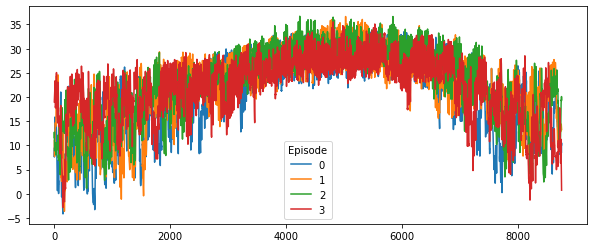

In [16]:
# confirm if climate zone 5's data is a repitition of TMY or is AMY
plot_data = weather_data[weather_data['climate_zone']=='5'].copy()
fig, ax = plt.subplots(1,1,figsize=(10,4))
episode_timesteps = 8760

for e, i in enumerate(range(0,plot_data.shape[0],episode_timesteps)):
    y = plot_data.iloc[i:i+episode_timesteps]['Outdoor Drybulb Temperature [C]'].tolist()
    ax.plot(range(episode_timesteps),y,label=e)

ax.legend(title='Episode')
plt.show()

In [17]:
print(weather_data.columns)

Index(['Outdoor Drybulb Temperature [C]', 'Outdoor Relative Humidity [%]',
       'Diffuse Solar Radiation [W/m2]', 'Direct Solar Radiation [W/m2]',
       '6h Prediction Outdoor Drybulb Temperature [C]',
       '12h Prediction Outdoor Drybulb Temperature [C]',
       '24h Prediction Outdoor Drybulb Temperature [C]',
       '6h Prediction Outdoor Relative Humidity [%]',
       '12h Prediction Outdoor Relative Humidity [%]',
       '24h Prediction Outdoor Relative Humidity [%]',
       '6h Prediction Diffuse Solar Radiation [W/m2]',
       '12h Prediction Diffuse Solar Radiation [W/m2]',
       '24h Prediction Diffuse Solar Radiation [W/m2]',
       '6h Prediction Direct Solar Radiation [W/m2]',
       '12h Prediction Direct Solar Radiation [W/m2]',
       '24h Prediction Direct Solar Radiation [W/m2]', 'climate_zone'],
      dtype='object')


Will leave out CZ 5 from analysis for now since it uses AMY data and we don't have the code that predicts relevant weather params in weather file to use to design TMY data.

In [34]:
# generate 10X weather and building timeseries data for all climate zones but 5
episode_count = 10

# copy default data to new location
directory = 'data_reward_function_exploration'

if os.path.isdir(directory):
    shutil.rmtree(directory)
else:
    pass

destination = shutil.copytree(data_directory,directory)

for (building_id, climate_zone), group in building_timeseries_data.groupby(['building_id','climate_zone']):
    if climate_zone == '5':
        continue
    else:
        group = group.drop(columns=['building_id','climate_zone'])
        group = pd.concat([group for _ in range(episode_count)],ignore_index=True)
        filepath = os.path.join(directory,f'Climate_Zone_{climate_zone}/Building_{building_id}.csv')
        group.to_csv(filepath,index=False)

for climate_zone, group in weather_data.groupby(['climate_zone']):
    if climate_zone == '5':
        continue
    else:
        group = group.drop(columns=['climate_zone'])
        group = pd.concat([group for _ in range(episode_count)],ignore_index=True)
        filepath = os.path.join(directory,f'Climate_Zone_{climate_zone}/weather_data.csv')
        group.to_csv(filepath,index=False)

for climate_zone, group in solar_generation_data.groupby(['climate_zone']):
    if climate_zone == '5':
        continue
    else:
        group = group.drop(columns=['climate_zone'])
        group_list = []

        for i in range(episode_count):
            temp_data = group.copy()
            temp_data['Hours since 00:00 Jan 1'] += episode_timesteps*i
            group_list.append(temp_data)
        
        group = pd.concat(group_list,ignore_index=True)
        filepath = os.path.join(directory,f'Climate_Zone_{climate_zone}/solar_generation_1kW.csv')
        group.to_csv(filepath,index=False)

# carbon intensity is only available for climate zone 5 for AMY
# take average and repeat 10 times
data = carbon_intensity_data.copy()
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['month'] = data['Datetime'].dt.month
data['day'] = data['Datetime'].dt.day
data['hour'] = data['Datetime'].dt.hour
data = data.groupby(['month','day','hour'])[['kg_CO2/kWh']].mean()
data = data.reset_index()
# remove leap year 2/29
ixs = data[
    (data['month']==2)
    &(data['day']==29)
].index
data = data.drop(ixs)
data = pd.concat([data for _ in range(episode_count)],ignore_index=True)

for climate_zone in range(1,5):
    filepath = os.path.join(directory,f'Climate_Zone_{climate_zone}/carbon_intensity.csv')
    data.to_csv(filepath,index=False)

# Reward Function Design
***
$E$ is an array of the district buildings' electricity demand, $n$ is the number of buildings in the district and $t$ is the current timestep.

1. __Default__
    $$
    r(t)^\textrm{def} = E(t)
    $$

2. __MARLISA__
    $$
    r(t)^\textrm{marl} = \textrm{sign}\left(r(t)^\textrm{def}\right) 
                            \times 0.01 
                                \times \left|{r(t)^\textrm{def}}\right|^2 
                                        \times \textrm{max}\left(
                                            0, 
                                            -\sum_{i=1}^{n-1}{r(t)^\textrm{def}_i}
                                        \right)

    $$

3. __SAC__
    $$
    r(t)^\textrm{sac} = \left[
        \textrm{min}\left(
            0,
            {r(t)_0^\textrm{def}}^3
        \right),
        \dots,
        \textrm{min}\left(
            0,
            {r(t)_{n-1}^\textrm{def}}^3
        \right)
    \right]
    $$

4. __Ramping Square__
    $$
    r(t)^\textrm{ramp} = \left[
        -\left(\left(
            \sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}
        \right)^2\right)_0,
        \dots,
        -\left(\left(
            \sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}
        \right)^2\right)_{n-1},
    \right] \div n
    $$

5. __Exponential__
    $$
    r(t)^\textrm{exp} = \left[
        \left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_0,
        \dots,
        \left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_{n-1}
    \right] \div n
    $$

    Where 0.0002 is a scaling factor to avoid high exponents defined as $\frac{\lambda}{50}$. We use $\lambda = 0.01$.

6. __Mixed__
    $$
    r(t)^\textrm{mix} = r(t)^\textrm{ramp} + r(t)^\textrm{exp}
    $$

# Simulation Analysis
***

In [3]:
simulations = {}
directory = os.path.join('data_reward_function_exploration','reward_function_exploration')

for style in reward_function_ma.get_styles():
    filepath = os.path.join(directory,f'{style}.pkl')

    try:
        with open(filepath,'rb') as f:
            simulations[style] = pickle.load(f)
    except FileNotFoundError as e:
        print(f'No simulation results for {style} reward style.')

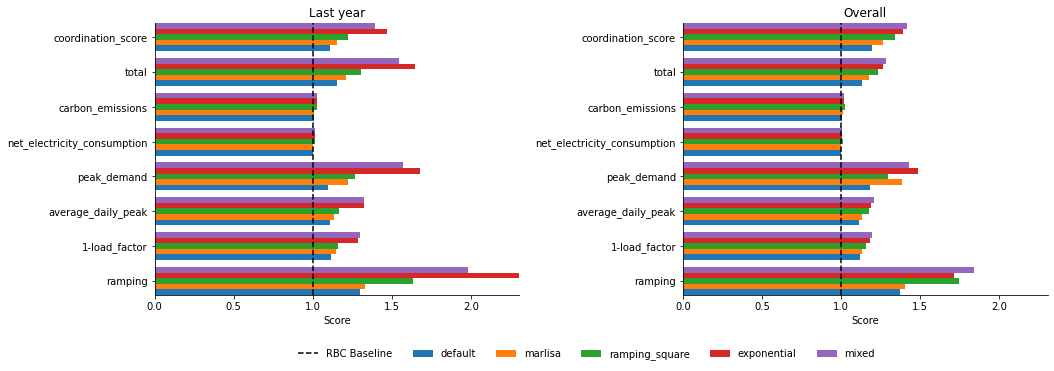

In [12]:
# cost functions
fig, axs = plt.subplots(1,2,figsize=(8*2,5),sharey=False,sharex=True,gridspec_kw={'wspace':0.45})
x_ticks = np.arange(len(
    simulations[list(simulations.keys())[0]]['env'].cost()[0]
))
overall_cost_x_tick_labels = simulations[list(simulations.keys())[0]]['env'].cost()[0].keys()
last_year_cost_x_tick_labels = simulations[list(simulations.keys())[0]]['env'].cost()[0].keys()
width = 0.16

for i, (style, simulation) in enumerate(simulations.items()):
    style_x_ticks = [(x_tick - width*len(simulations)/2) + width*(i + 0.5) for x_tick in x_ticks]
    overall_cost, last_year_cost = simulation['env'].cost()
    axs[0].barh(style_x_ticks,last_year_cost.values(),width,label=style)
    axs[1].barh(style_x_ticks,overall_cost.values(),width,label=style)

for ax, title, y_tick_labels in zip(fig.axes, ['Last year','Overall'], [last_year_cost_x_tick_labels,overall_cost_x_tick_labels]):
    ax.axvline(1,color='black',linestyle='--',label='RBC Baseline')
    ax.set_xlabel('Score')
    ax.set_title(title)
    ax.set_yticks(x_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(axis='y',rotation=0)
    ax.margins(0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.axes[0].legend(bbox_to_anchor=(0.5,0),
    loc='upper center', 
    bbox_transform=fig.transFigure,
    framealpha=0,
    ncol=len(simulations)+1
)
# plt.tight_layout()
plt.show()
